In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pynwb import NWBFile, NWBHDF5IO

In [2]:
# Specify data path and filename(s)
data_dir = os.path.join('..','data', 'nwb2.0')
fname = 'mouse1_fni16_150821_001-002_ch2-PnevPanResults-170808-184141.nwb'

In [3]:
# Read NWB 2.0 file
nwb_io = NWBHDF5IO(os.path.join(data_dir, fname), mode = 'r')
nwbfile = nwb_io.read()

In [4]:
# Extract all trial-based ROI time-series
# ROI time-series has the shape of: (ROI count) x (time instances) x (trial count)
roi_series = nwbfile.modules.get('Trial-based').data_interfaces.get('deconvolved dF-over-F').roi_response_series

In [5]:
# Display all event-type data are time locked to
for eve in roi_series.keys():
    print(eve)

commitIncorrAl
firstSideTryAl
firstSideTryAl_COM
goToneAl
initToneAl
rewardAl
stimAl_allTrs
stimAl_noEarlyDec
stimOffAl


In [6]:
def get_trialsegmented_data(event_name, pre_stim_dur, post_stim_dur, roi_series):
    d_obj = roi_series.get(event_name)
    data = np.array(d_obj.data)
    tvec = np.array(d_obj.timestamps)
    # check if pre/post stim duration is out of bound
    pre_stim_dur = np.minimum(tvec[0], pre_stim_dur)
    post_stim_dur = np.maximum(tvec[-1], post_stim_dur)   
    # extract data
    ix = np.logical_(tvec >= pre_stim_dur, tvec <= post_stim_dur)
    return data[:, ix, :], tvec[ix]    

In [7]:
# Obtain inh/exc status of the ROI
roi_tcourse = roi_series.get('initToneAl')
good_roi_mask = roi_tcourse.rois.data
roi_table = roi_tcourse.rois.table
neuron_type = roi_table.get('neuron_type').data[good_roi_mask]

### Reproduce Figure 1E

In [8]:
# specify event of interest to extract trial data 
segmentation_settings = [
    {'event':'initToneAl', 'pre': -10000, 'post': 100},
    {'event':'stimAl_noEarlyDec', 'pre': -100, 'post': 10000},
    {'event':'firstSideTryAl', 'pre': -250, 'post': 250},
    {'event':'rewardAl', 'pre': -250, 'post': 10000}]

# extract trial-based data and average over trial
trial_avg_segments = {}
for setting in segmentation_settings:
    # extract segment
    out = get_trialsegmented_data(setting['event'], setting['pre'], setting['post'], roi_series)
    # average
    trial_avg_segments[setting['event']] = (np.nanmean(out[0], axis=2), out[1])

In [9]:
# Function to sort the ROI time-series based on the latency of the peak activity
def roi_sort_by_peak_latency(roi_tcourse):
    sorted_roi_idx = np.argsort(np.argmax(roi_tcourse, axis = 1))
    return roi_tcourse[sorted_roi_idx,:].copy(), sorted_roi_idx

In [10]:
# Sort and concatenate trial-based data time-locked to: start tone, stimulus, 1st commit and 2nd commit

# Concatenate and sort
data_all = np.hstack((value[0] for value in trial_avg_segments.values())
data_all, sorted_roi_idx = roi_sort_by_peak_latency(data_all)

# Concatenate all timevec(s) and determine the indices of t = 0
tvec_concat = [value[1] for value in trial_avg_segments.values()]
xdim_all = [t.size for t in tvec_concat]
xdim_all.insert(0,0)
zeros_all = [np.where(v == 0)[0][0] for v in tvec_concat]

# Extract inh/exc status
is_inh = np.zeros((data_all.shape[0]))
is_inh[neuron_type[sorted_roi_idx] == 'inhibitory'] = 1

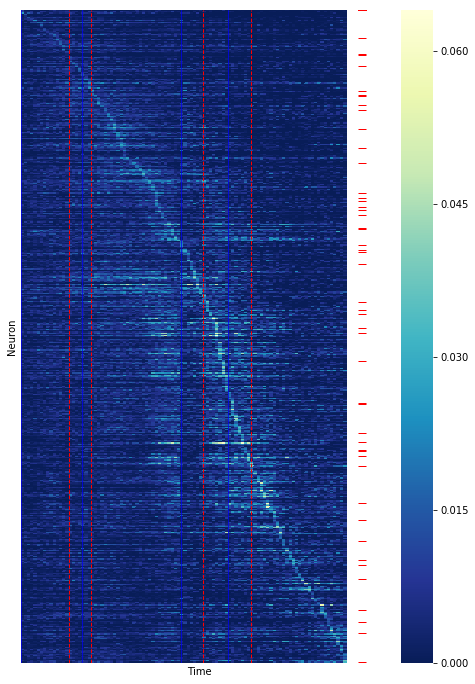

In [59]:
# Raster Plot -  Figure 1E
fig1E = plt.figure(figsize=(8,12))
ax1 = fig1E.add_subplot(111)
ax1.set_facecolor('white')

sns.heatmap(data=data_all, xticklabels=[], yticklabels=[], cmap='YlGnBu_r', axes=ax1, vmin=0)

# add vertical lines
for zidx, z in enumerate(zeros_all):
    ax1.axvline(x=np.cumsum(xdim_all)[zidx], color='b',linestyle='-',linewidth=0.7)
    ax1.axvline(x=z + np.cumsum(xdim_all)[zidx], color='r',linestyle='--',linewidth=1)
    
# add inhibitor marker
ax1.plot(np.ones(is_inh.shape)*(data_all.shape[1]+5), np.arange(is_inh.size)*is_inh, 'r_', markersize=8)

ax1.set_xlim(0, data_all.shape[1]+10)
ax1.set_xlabel('Time')
ax1.set_ylabel('Neuron')
ax1.set_label('Averaged infered spike for all neurons for an example session')

### Reproduce Figure 1F

In [12]:
# Get trial info
trial_set = nwbfile.trials
print(trial_set.colnames)

('start_time', 'stop_time', 'trial_type', 'trial_pulse_rate', 'trial_response', 'trial_is_good', 'init_tone', 'stim_onset', 'stim_offset', 'go_tone', 'first_commit', 'second_commit')


In [13]:
trial_is_good = trial_set.get('trial_is_good').data
trial_response_type = trial_set.get('trial_response').data
trial_type = trial_set.get('trial_type').data

In [14]:
# make trial-mask for correct high-rate (ipsilateral-lick) and low-rate (contralateral-lick) trial
correct_high_rate_trial = np.logical_and(trial_response_type == 'correct', trial_type == 'High-rate')
correct_low_rate_trial = np.logical_and(trial_response_type == 'correct', trial_type == 'Low-rate')

In [15]:
# make mask of inhibitory and excitatory neuron
is_inh = (neuron_type == 'inhibitory')
is_exc = (neuron_type == 'excitatory')

In [16]:
# specify event of interest to extract trial data 
segmentation_settings = [
    {'event':'initToneAl', 'pre': -10000, 'post': 100},
    {'event':'stimAl_noEarlyDec', 'pre': -100, 'post': 10000},
    {'event':'firstSideTryAl', 'pre': -250, 'post': 250},
    {'event':'rewardAl', 'pre': -250, 'post': 10000}]

trial_avg_segments = {}
for setting in segmentation_settings:
    # extract segment
    out = get_trialsegmented_data(setting['event'], setting['pre'], setting['post'], roi_series)
    # mask by high/low rate trial and inh/exc neuron type
    exc_correct_hr = out[0][:,:,correct_high_rate_trial][is_exc,:,:]
    inh_correct_hr = out[0][:,:,correct_high_rate_trial][is_inh,:,:]
    exc_correct_lr = out[0][:,:,correct_low_rate_trial][is_exc,:,:]
    inh_correct_lr = out[0][:,:,correct_low_rate_trial][is_inh,:,:]
    # take average across trials
    trial_avg_segments[setting['event']] = {'exc_correct_hr':np.nanmean(exc_correct_hr, axis=2),
                                            'inh_correct_hr':np.nanmean(inh_correct_hr, axis=2),
                                            'exc_correct_lr':np.nanmean(exc_correct_lr, axis=2),
                                            'inh_correct_lr':np.nanmean(inh_correct_lr, axis=2),
                                            'timestamps':out[1]}

In [64]:
# plot a single subplot of Figure 1F
def plot_sub_fig1F(exc_ax, inh_ax, trial_avg_segments, exc_idx, inh_idx):    
  
    # make a nan-padding between each dataset 
    pad_size = 3
    nan_padding = np.full(pad_size, np.nan)
    
    # Concatenate and add nan padding in between    
    r = {k: np.hstack(np.hstack((v[k][idx,:], nan_padding)) for v in trial_avg_segments.values()) 
                       for k, idx in (('exc_correct_hr', exc_idx),
                                      ('inh_correct_hr', inh_idx),
                                      ('exc_correct_lr', exc_idx),
                                      ('inh_correct_lr', inh_idx))}    
    tvec = np.hstack(np.hstack((v['timestamps'], nan_padding)) for v in trial_avg_segments.values())      
    
    # determine the indices of t = 0
    t_zeros = np.where(tvec == 0)[0]

    for ax, roi_key in ((exc_ax, ('exc_correct_lr', 'exc_correct_hr')),  (inh_ax, ('inh_correct_lr', 'inh_correct_hr'))):
            ax.plot(r[roi_key[0]], 'k', alpha=0.6) 
            ax.plot(r[roi_key[1]], 'g', alpha=0.8)   
            # add vertical lines
            for t in t_zeros:
                ax.axvline(x=t, color='k', linestyle='--', linewidth=0.7)
                ax.set_facecolor('w')
                ax.set_xticklabels([])
                ax.set_title(roi_key[0].split('_')[0])

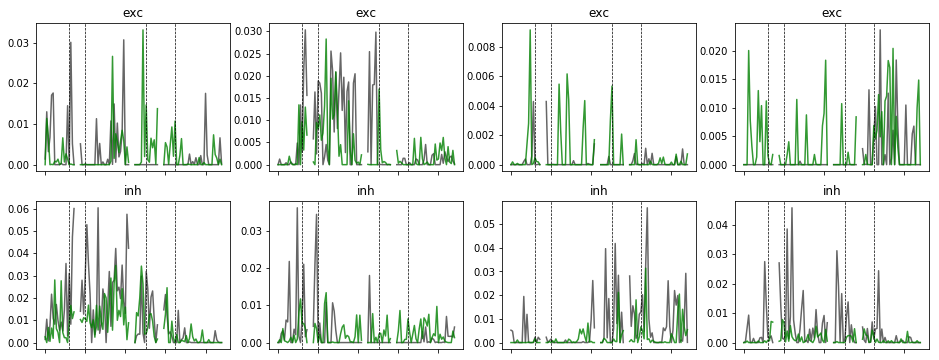

In [65]:
# Plot figure 1F
fig1F, axes = plt.subplots(2, 4, figsize=(16,6))
for a, e, i in zip(axes.T, [10, 11, 22, 25], [5, 6, 7, 8]):
    plot_sub_fig1F(a[0], a[1], trial_avg_segments, e, i)

In [19]:
nwb_io.close()